In [43]:
import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time

from sionna.mimo import StreamManagement

from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer
from sionna.ofdm import OFDMModulator, OFDMDemodulator, ZFPrecoder, RemoveNulledSubcarriers

from sionna.channel.tr38901 import AntennaArray, CDL, Antenna
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel, time_lag_discrete_time_channel
from sionna.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel, TimeChannel

from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

from sionna.mapping import Mapper, Demapper

from sionna.utils import BinarySource, ebnodb2no, sim_ber
from sionna.utils.metrics import compute_ber
# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

In [45]:
# Load integrated scene
# scene = load_scene("./Single Box/Single Box.xml") # Try also sionna.rt.scene.etoile
scene = load_scene(sionna.rt.scene.etoile) # Try also sionna.rt.scene.etoile

In [46]:
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")



# Add transmitter instance to scene
tx_object = scene.get("tx")
if tx_object is not None:
    scene.remove("tx")
# Create transmitter
tx = Transmitter(name="tx",
                 position=[8.5,21,27])
scene.add(tx)

rx_object = scene.get("rx")
if rx_object is not None:
    scene.remove("rx")
rx = Receiver(name="rx",
              position=[60,50,1.5],
              orientation=[0,0,0])
scene.add(rx)
tx.look_at(rx)


In [47]:
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")



# Add transmitter instance to scene
tx_object = scene.get("tx")
if tx_object is not None:
    scene.remove("tx")
# Create transmitter
tx = Transmitter(name="tx",
                 position=[8.5,10,10])
scene.add(tx)

rx1_object = scene.get("rx1")
if rx1_object is not None:
    scene.remove("rx1")
# Create a receiver
rx_tmp = Receiver(name="rx1",
              position=[-8,-10,1.5],
              orientation=[0,0,0])

# Add receiver instance to scene
scene.add(rx_tmp)

tx.look_at(rx_tmp) # Transmitter points towards receiver
rx_object = scene.get("rx")
if rx_object is not None:
    scene.remove("rx")
rx = Receiver(name="rx",
              position=[8.5,10,10],
              orientation=[0,0,0])
scene.add(rx)
rx.look_at(rx_tmp)
scene.remove("rx1")


In [48]:
scene.frequency = 20e9 # in Hz; implicitly updates RadioMaterials
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [49]:
paths = scene.compute_paths(max_depth=3,num_samples=1e6,los=True,reflection=True,scattering=True,diffraction=True)
paths.normalize_delays = False

In [50]:
scene.preview(paths=paths,show_paths=True)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [51]:
a, tau = paths.cir()
print("Shape of tau: ", tau.shape)

Shape of tau:  (1, 1, 1, 906)


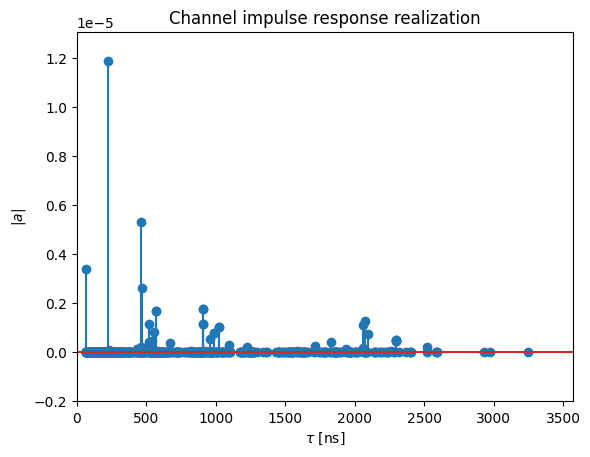

In [52]:
t = tau[0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,0,:,0]
a_max = np.max(a_abs)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");


In [53]:
num_ut = 1
num_bs = 1
num_ut_ant = 1
num_bs_ant = 1
num_streams_per_tx = num_ut_ant
rx_tx_association = np.array([[1]])
sm = StreamManagement(rx_tx_association, num_streams_per_tx)

In [54]:
fft_size = 700
cp_length = 6
rg = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=fft_size,
                  subcarrier_spacing=15e3,
                  num_tx=1,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=cp_length,
                  num_guard_carriers=[5,6],
                  dc_null=True,
                  pilot_pattern="kronecker",
                  pilot_ofdm_symbol_indices=[2,11])

In [55]:
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)
h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=True)

In [56]:
channel_freq = ApplyOFDMChannel(add_awgn=True)

In [57]:
num_bits_per_symbol = 2 # QPSK modulation
coderate = 0.5 # Code rate
l_min, l_max = time_lag_discrete_time_channel(rg.bandwidth)
n = int(rg.num_data_symbols*num_bits_per_symbol) # Number of coded bits
k = int(n*coderate) # Number of information bits

# The binary source will create batches of information bits
binary_source = BinarySource()

# The encoder maps information bits to coded bits
encoder = LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = Mapper("qam", num_bits_per_symbol)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = ResourceGridMapper(rg)

# The zero forcing precoder precodes the transmit stream towards the intended antennas
zf_precoder = ZFPrecoder(rg, sm, return_effective_channel=True)

# OFDM modulator and demodulator
modulator = OFDMModulator(rg.cyclic_prefix_length)
demodulator = OFDMDemodulator(rg.fft_size, l_min, rg.cyclic_prefix_length)

# This function removes nulled subcarriers from any tensor having the shape of a resource grid
remove_nulled_scs = RemoveNulledSubcarriers(rg)

# The LS channel estimator will provide channel estimates and error variances
ls_est = LSChannelEstimator(rg, interpolation_type="nn")

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
lmmse_equ = LMMSEEqualizer(rg, sm)

# The demapper produces LLR for all coded bits
demapper = Demapper("app", "qam", num_bits_per_symbol)

# The decoder provides hard-decisions on the information bits
decoder = LDPC5GDecoder(encoder, hard_out=True)

In [58]:
batch_size = 50
ebno_db = 10
perfect_csi = False # Change to switch between perfect and imperfect CSI

# Compute the noise power for a given Eb/No value.
# This takes not only the coderate but also the overheads related pilot
# transmissions and nulled carriers
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)

b = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
c = encoder(b)
x = mapper(c)
x_rg = rg_mapper(x)
# x_rg,g = zf_precoder([x_rg, h_freq])
y = channel_freq([x_rg, h_freq, no])
if perfect_csi:
    # For perfect CSI, the receiver gets the channel frequency response as input
    # However, the channel estimator only computes estimates on the non-nulled
    # subcarriers. Therefore, we need to remove them here from `h_freq`.
    # This step can be skipped if no subcarriers are nulled.
    h_hat, err_var = h_freq, 0.
else:
    h_hat, err_var = ls_est ([y, no])

x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)
ber = compute_ber(b, b_hat)
print("BER: {}".format(ber))

BER: 0.0


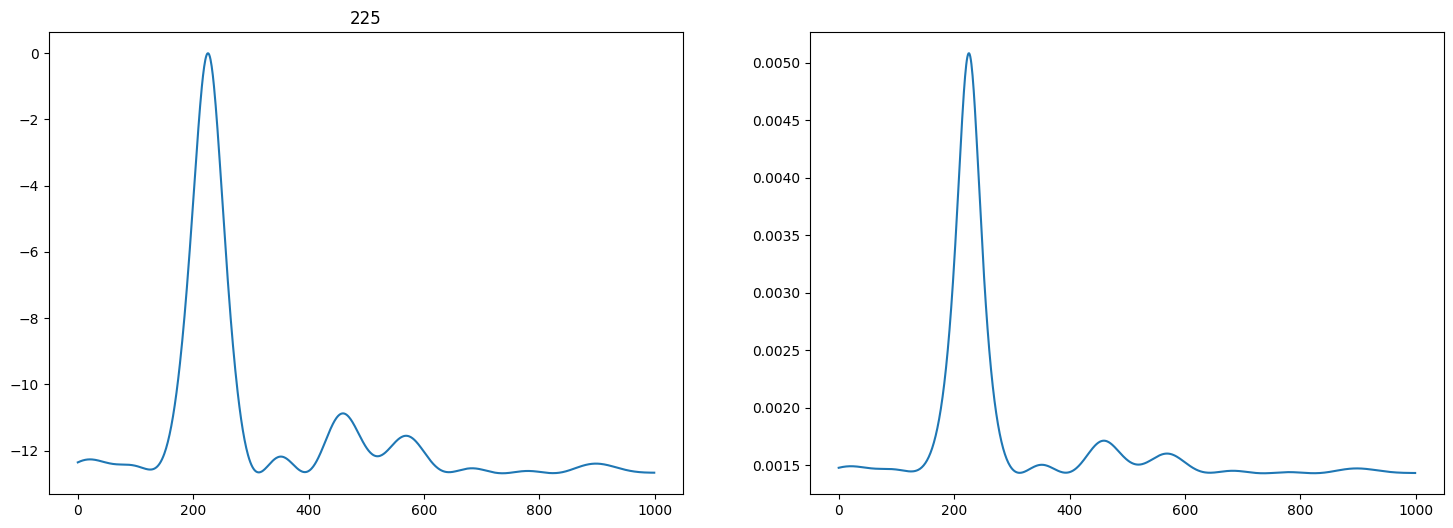

In [59]:
y_i = h_freq[0,...]
y_i = tf.squeeze(y_i)
y_i = tf.expand_dims(y_i, axis=0)
y_i_H = tf.transpose(tf.math.conj(y_i))
y_conv = tf.matmul(y_i_H, y_i)
eig_vals, eig_vecs = tf.linalg.eigh(y_conv)
tau_range = np.arange(0, 1000, 1)
frequencies_c = tf.cast(frequencies, dtype=tf.complex64)

P_tau_array = tf.TensorArray(dtype=tf.complex64, size=len(tau_range))
G_n = tf.cast(eig_vecs[:,:-1], dtype=tf.complex64)
G_n_H = tf.math.conj(tf.transpose(G_n))
for idx in range(len(tau_range)):
    a_m = tf.expand_dims(tf.math.exp(-1j * 2 * np.pi * frequencies_c * (tau_range[idx]/1e9)), axis=0)
    a_m_H = tf.math.conj(tf.transpose(a_m))
    P_tau_array = P_tau_array.write(idx, 1 / (a_m @ G_n @ G_n_H @ a_m_H))

P_tau = P_tau_array.stack()
# 计算谱函数
P_tau_real, P_tau_imag = tf.math.real(P_tau), tf.math.imag(P_tau)
P_abs = tf.math.sqrt(P_tau_real**2 + P_tau_imag**2)
P_norm = 10 * tf.math.log(P_abs / tf.reduce_max(P_abs), 10)
P_norm = tf.squeeze(P_norm)
max_idx = tf.argmax(P_norm)
# 绘制
# 调整画布大小
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(tau_range, tf.squeeze(P_norm))
plt.title(f"{max_idx-1}")
plt.subplot(1, 2, 2)
plt.plot(tau_range, tf.squeeze(P_abs))

In [60]:
snr = ebno_db
H=a[0,0,0,0,0,:,0]
H=H[H!=0]
H_H = np.conj(H)
l = len(H)
B = tf.reshape(H_H, [l,1]) @ tf.reshape(H, [1,l])
B_inv = tf.linalg.inv(B)
B_diag = tf.linalg.diag_part(B_inv)
crb1 = tf.abs(tf.cast(B_diag,tf.complex128)) / tf.cast((8 * np.pi**2 * snr * rg.bandwidth **2),tf.float64)

In [61]:
#CRB 2
import math
snr = 10*math.log(ebno_db,10)
alpha=paths.a[0,0,0,0,0,:,0]
tau=paths.tau[0,0,0,:]
tau=tau[alpha!=0]
alpha=alpha[alpha!=0]
length = len(alpha)
tau_i = tf.repeat(tau,length)
tau_i = tf.reshape(tau_i, (length,length))
tau_j = tf.transpose(tau_i)
tau_i_mine_j = tau_i- tau_j
tau_i_mul_j = tau_i* tau_j
alpha_ij = tf.reshape(alpha, (length,1)) @ tf.reshape(alpha, (1,length))
one = tf.ones((length,length))
F_alpha= 2*snr*tf.math.abs(alpha_ij)/(tau_i_mul_j**2)
F_cos = (one+4*(np.pi**2)*(scene.frequency**2) * tau_i_mul_j)*tf.math.cos(2*np.pi*scene.frequency*tau_i_mine_j)
F_sin = 2*np.pi*scene.frequency*tau_i_mine_j*tf.math.sin(2*np.pi*scene.frequency*tau_i_mine_j)
F = F_alpha*(F_cos+F_sin)
crb_F = tf.linalg.inv(F)
crb2 = tf.linalg.diag_part(crb_F)

In [62]:
#CRB 3
snr = ebno_db
H=a[0,0,0,0,0,:,0]
tau=paths.tau[0,0,0,:]
tau = tau[H!=0]
H = H[H!=0]
H_H = np.conj(H)
l = len(H)
length = len(H)
tau_i = tf.repeat(tau,length)
tau_i = tf.reshape(tau_i, (length,length))
tau_j = tf.transpose(tau_i)
tau_i_mine_j = tau_i- tau_j
tau_i_mul_j = tau_i* tau_j
B_1 = tf.reshape(H_H, [l,1]) @ tf.reshape(H, [1,l])
one = tf.ones((length,length))
real = one + 4*(np.pi**2)*(scene.frequency**2) * tau_i_mul_j
img = 2*np.pi*scene.frequency*tau_i_mine_j
B_2 = tf.complex(real, img)
B_total = tf.abs(B_1*B_2)
B_total = B_total/tau_i_mul_j**2
crb3 = tf.linalg.diag_part(tf.linalg.inv(tf.abs(B_total)))

In [63]:
# 选出a最大对应的tau的下标
c = 3e8
crb1 = tf.math.abs(crb1)
crb2 = tf.math.abs(crb2)
crb3 = tf.math.abs(crb3)
a_sortidx = np.argsort(np.abs(a[0,0,0,0,0,:,0]))
H_sortidx = np.argsort(np.abs(H))
tau_true = tf.squeeze(tau)[a_sortidx[-1]]
tau_est = tf.cast(max_idx,tf.float32)/1e9
mse = (tau_true - tau_est)**2
crb = crb3[H_sortidx[-1]]
# crb = tf.math.reduce_mean(crb2)
print
print(f"range_true: {tau_true*c:.6f}m\nrange_est: {tau_est*c:.6f}m\nerror: {np.abs(tau_true-tau_est)*c:.6f}m \nmse: {mse:.24f}\ncrb: {crb:.24f}")
print(f"{tau_true*c:.3f}\t{tau_est*c:.3f}\t{np.abs(tau_true-tau_est)*c:.3f}\t{mse}\t{crb}")

range_true: 66.812035m
range_est: 67.799995m
error: 0.987967m 
mse: 0.000000000000000010845320
crb: 0.000000000000000000023032
66.812	67.800	0.988	1.0845319693957293e-17	2.3031664777931314e-20
